In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.preprocessing import StandardScaler, label_binarize
from itertools import cycle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
import joblib
import pandas_profiling

ImportError: cannot import name 'DataError' from 'pandas.core.base' (C:\Users\Kuba\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\base.py)

In [100]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3])
    disp.plot(cmap = 'Blues')
    print(classification_report(y_test, y_pred))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 3
    y_pred_binarized = label_binarize(y_pred, classes=[1, 2, 3])
    y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw = 2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )
    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curves for all labels")
    plt.legend(loc="lower right")
    plt.show()

def get_best_estimator(datasetName, x_train, x_test, y_train, y_test):
    estimators = dict()

    k_neighbors_params = {
        'n_neighbors': [15]
    }
    estimators[KNeighborsClassifier()] = k_neighbors_params

    random_forest_params = {
        'n_estimators': [100],
        'random_state': [1]
    }
    estimators[RandomForestRegressor()] = random_forest_params


    gaussian_nb_params = {'var_smoothing': np.logspace(0,-9, num=100)}
    estimators[GaussianNB()] = gaussian_nb_params
    bernoulli_gs_params = {
        'fit_prior': [True, False],
        'alpha': [a/10 for a in range(1, 11)]
    }
    estimators[BernoulliNB()] = bernoulli_gs_params

    svc_params = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf']}
    estimators[SVC()] = svc_params

    dt_params = {
        'max_depth': [x for x in range(2, 9)],
        'min_samples_leaf': [x for x in range(1, 10)],
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [x for x in range(2, 10)],
        'max_leaf_nodes': np.concatenate(([None], [x for x in range(5, 100, 5)])),
        'max_features': np.concatenate(([None], [x for x in range(1, x_train.shape[1])]))
    }
    estimators[tree.DecisionTreeClassifier()] = dt_params

    results = []
    for estimator, params in estimators.items():
        print(estimator.__class__.__name__)
        gs = GridSearchCV(estimator=estimator, param_grid=params,
                          cv=4, n_jobs=-1, scoring = "accuracy")
        clf = gs.fit(x_train, y_train)

        results.append({
            'estimator': clf.best_estimator_,
            'score': clf.score(x_test, y_test),
            'params': clf.best_estimator_.get_params()
        })
        print(clf.score(x_test, y_test))
        print(clf.best_estimator_.get_params())
        joblib.dump(clf, str.join('/', ['models', datasetName, str(estimator).replace('()', '')]))
        y_pred = clf.predict(x_test)
        evaluate(y_test, y_pred)

    results = sorted(results, key=lambda x: x['score'], reverse=True)
    data = pd.DataFrame(results)
    data
    return results[0]

In [20]:
data: pd.DataFrame = pd.read_excel('deers.xlsx', sheet_name='DATA')
czech_data = data[data["MIEJSCE"] == "CZ"]
other_countries = data[data["MIEJSCE"] != "CZ"].drop(['P_CON_CO', 'P_B', 'P_ZL', 'P_M3', 'M1_M3', 'N_RH', 'DA_DA', 'FS_FS', 'GOV_CR', 'P_M3Ż'], axis=1)

In [21]:
pandas_profiling.ProfileReport(czech_data, vars={"num": {"low_categorical_threshold": 0}})

NameError: name 'pandas_profiling' is not defined

In [ ]:
pandas_profiling.ProfileReport(other_countries, vars={"num": {"low_categorical_threshold": 0}})

In [22]:
czech_data.count()

WIEK        300
KLASA       300
TUSZA       287
P_CON_CO    290
P_OP        281
P_B         293
ST_P        288
P_ZL        299
P_M3        269
M1_M3       257
PM_P        300
N_RH        296
ZY_ZY       300
ECT_ECT     300
DA_DA       300
FS_FS       210
EU_EU       300
CON_CON     293
ID_GOC      292
GOV_CR      292
P_M3Ż       254
C_P1        293
CIEZARPO    184
MIEJSCE     300
ROK         300
dtype: int64

In [23]:
czech_data = czech_data.fillna(
    {"TUSZA": czech_data.groupby(['KLASA'])["TUSZA"].transform("mean"),
     "P_CON_CO": czech_data.groupby(['KLASA'])["P_CON_CO"].transform("mean"),
     "P_OP": czech_data.groupby(['KLASA'])["P_OP"].transform("mean"),
     "P_B": czech_data.groupby(['KLASA'])["P_B"].transform("mean"),
     "ST_P": czech_data.groupby(['KLASA'])["ST_P"].transform("mean"),
     "P_ZL": czech_data.groupby(['KLASA'])["P_ZL"].transform("mean"),
     "N_RH": czech_data.groupby(['KLASA'])["N_RH"].transform("mean"),
     "CON_CON": czech_data.groupby(['KLASA'])["CON_CON"].transform("mean"),
     "ID_GOC": czech_data.groupby(['KLASA'])["ID_GOC"].transform("mean"),
     "GOV_CR": czech_data.groupby(['KLASA'])["GOV_CR"].transform("mean"),
     "C_P1": czech_data.groupby(['KLASA'])["C_P1"].transform("mean"),
     "P_M3": czech_data.groupby(['KLASA'])["P_M3"].transform("mean"),
     "M1_M3": czech_data.groupby(['KLASA'])["M1_M3"].transform("mean"),
     "FS_FS": czech_data.groupby(['KLASA'])["FS_FS"].transform("mean"),
     "P_M3Ż": czech_data.groupby(['KLASA'])["P_M3Ż"].transform("mean"),
     "CIEZARPO": czech_data.groupby(['KLASA'])["CIEZARPO"].transform("mean"),
    })

czech_data = czech_data.drop(['CIEZARPO', 'TUSZA', 'MIEJSCE'], axis=1)
czech_data.count()

WIEK        300
KLASA       300
P_CON_CO    300
P_OP        300
P_B         300
ST_P        300
P_ZL        300
P_M3        300
M1_M3       300
PM_P        300
N_RH        300
ZY_ZY       300
ECT_ECT     300
DA_DA       300
FS_FS       300
EU_EU       300
CON_CON     300
ID_GOC      300
GOV_CR      300
P_M3Ż       300
C_P1        300
ROK         300
dtype: int64

In [24]:
other_countries = other_countries.fillna({
    "TUSZA": other_countries.groupby('KLASA')["TUSZA"].transform("mean"),
    "ST_P": other_countries.groupby('KLASA')["ST_P"].transform("mean"),
    "PM_P": other_countries.groupby('KLASA')["PM_P"].transform("mean"),
    "ZY_ZY": other_countries.groupby('KLASA')["ZY_ZY"].transform("mean"),
    "EU_EU": other_countries.groupby('KLASA')["EU_EU"].transform("mean"),
    "CON_CON": other_countries.groupby('KLASA')["CON_CON"].transform("mean"),
    "ID_GOC": other_countries.groupby('KLASA')["ID_GOC"].transform("mean"),
    "C_P1": other_countries.groupby('KLASA')["C_P1"].transform("mean"),
    "CIEZARPO": other_countries.groupby('KLASA')["CIEZARPO"].transform("mean"),
})

other_countries['MIEJSCE'] = other_countries['MIEJSCE'].map({'B': 0, 'K': 1})
other_countries

,WIEK,KLASA,TUSZA,P_OP,ST_P,PM_P,ZY_ZY,ECT_ECT,EU_EU,CON_CON,ID_GOC,C_P1,CIEZARPO,MIEJSCE,ROK
300,2,1,98.445312,376.4,203.200000,121.9,133.000000,160.0,91.700000,74.60000,282.3,92.7,1.000000,0,93
301,2,1,82.000000,354.9,226.307905,112.0,134.000000,149.2,93.000000,73.49321,266.2,88.0,1.000000,0,93
302,2,1,82.000000,350.0,207.000000,113.0,135.000000,155.0,90.200000,73.49321,277.5,95.0,1.000000,0,93
303,2,1,68.000000,359.0,213.800000,115.4,133.000000,150.5,102.000000,73.49321,273.2,87.5,0.500000,0,93
304,2,1,84.000000,349.8,213.200000,117.2,126.300000,159.2,92.300000,73.49321,286.0,97.0,0.500000,0,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,5,2,127.141732,420.2,249.000000,128.0,160.000000,176.8,99.000000,72.40000,316.0,104.2,3.650968,0,95
933,4,1,98.445312,401.0,228.800000,126.8,147.500000,163.2,94.811765,73.49321,305.5,102.0,1.875321,0,95
934,4,1,98.445312,444.3,225.500000,121.5,152.270189,167.2,98.800000,73.49321,305.0,99.5,1.875321,0,95
935,5,2,127.141732,414.8,239.500000,130.0,151.200000,169.2,99.000000,69.50000,309.0,99.2,3.650968,0,95


In [25]:
other_countries = other_countries.drop(['CIEZARPO', 'TUSZA'], axis=1)

Sam dataset jest podzielony na dwa (czeski i inne kraje) - poniewaz czesi maja najbardziej pelne dane, a w innych krajach duza czesc kolumn jest ZAWSZE pusta.
Mysle by zrobic dwa modele, ktory na podstawie pochodzenia bedzie decydowal, gdzie co przydzielic albo coś...

Wywalilem z obu datasetów CIERAZPO I TUSZA, poniewaz brakuje ok. 40% danych. Wiele kolumn jest wysoko ze soba skorelowanych, wiec powinno i tak dawac spoko wyniki.
Uzupelnianie w jakis sposob tak znaczacej ilosci danych wydaje mi sie ze moglo by wplynac mocno na wyniki klasyfikacji. Ale mozecie to zmienic.

Reszte danych jezeli cos brakowalo pododawalem srednia, z danej klasy co zostal rekord przydzielony.

In [46]:
x_czech = czech_data.drop(["KLASA"], axis=1)
y_czech = czech_data["KLASA"]

x_other = other_countries.drop(["KLASA"], axis=1)
y_other = other_countries["KLASA"]

x_train_cz, x_test_cz, y_train_cz, y_test_cz =  train_test_split(x_czech, y_czech, test_size=0.3)
x_train_o, x_test_o, y_train_o, y_test_o =  train_test_split(x_other, y_other, test_size=0.3)

scaler_cz = StandardScaler()
x_train_cz = scaler_cz.fit_transform(x_train_cz)
x_test_cz = scaler_cz.transform(x_test_cz)

scaler_o = StandardScaler()
x_train_o = scaler_o.fit_transform(x_train_o)
x_test_o = scaler_o.transform(x_test_o)

x_last = x_test_o
y_last = x_test_o

KNeighborsClassifier
0.8555555555555555
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
              precision    recall  f1-score   support

           1       0.91      0.92      0.92        53
           2       0.68      0.71      0.70        21
           3       0.93      0.81      0.87        16

    accuracy                           0.86        90
   macro avg       0.84      0.82      0.83        90
weighted avg       0.86      0.86      0.86        90



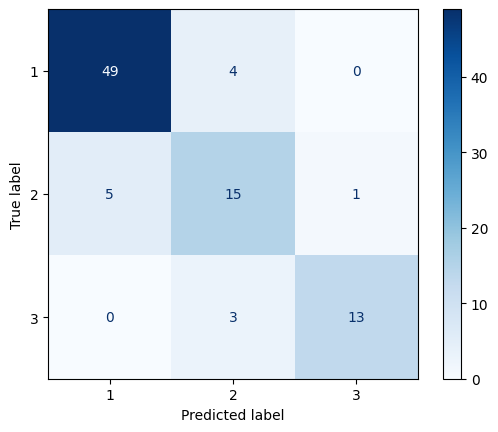

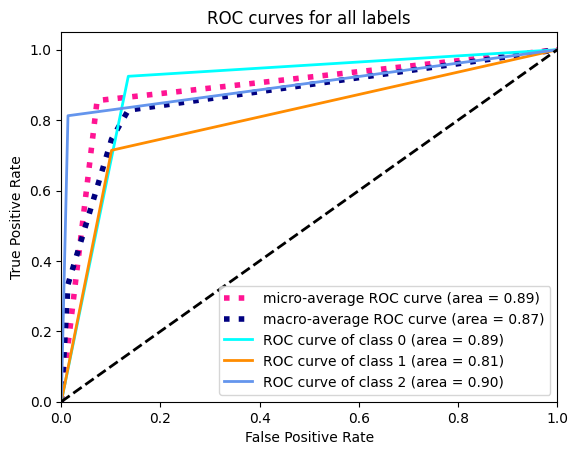

RandomForestRegressor
1.0
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        53
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        16

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



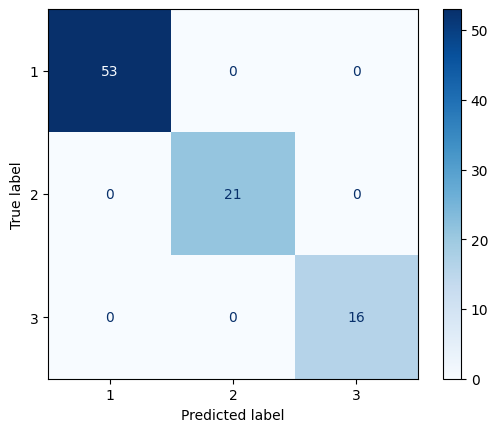

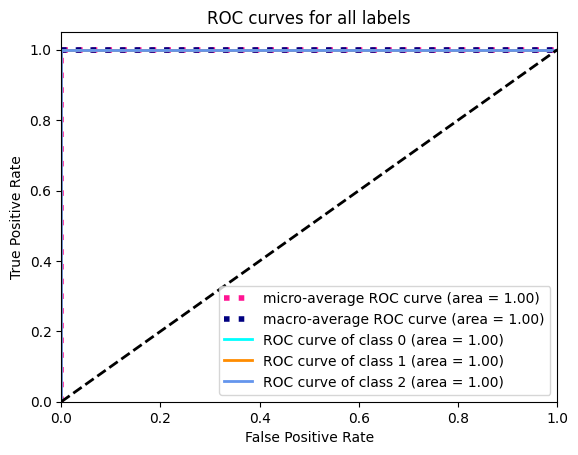

GaussianNB
0.7777777777777778
{'priors': None, 'var_smoothing': 0.001873817422860383}
              precision    recall  f1-score   support

           1       0.94      0.83      0.88        53
           2       0.52      0.67      0.58        21
           3       0.75      0.75      0.75        16

    accuracy                           0.78        90
   macro avg       0.73      0.75      0.74        90
weighted avg       0.81      0.78      0.79        90



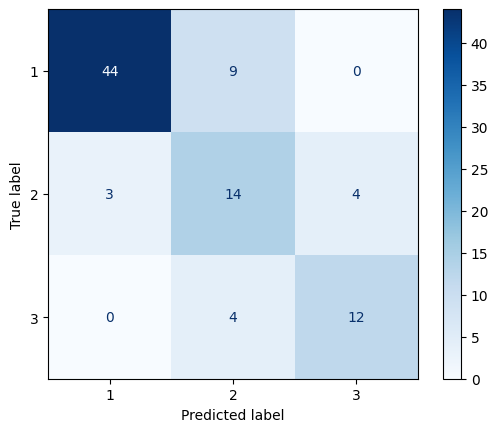

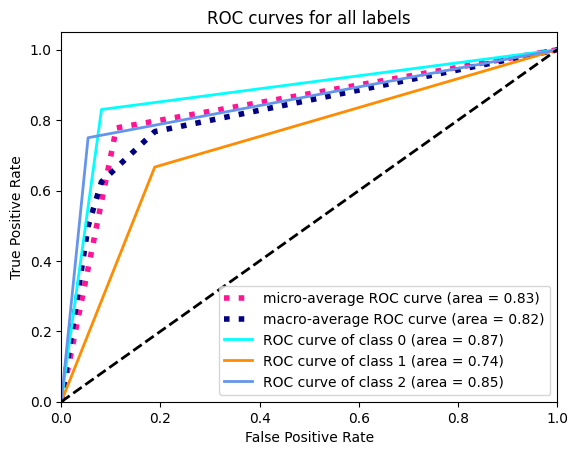

BernoulliNB
0.7666666666666667
{'alpha': 0.1, 'binarize': 0.0, 'class_prior': None, 'fit_prior': False}
              precision    recall  f1-score   support

           1       0.92      0.85      0.88        53
           2       0.50      0.48      0.49        21
           3       0.67      0.88      0.76        16

    accuracy                           0.77        90
   macro avg       0.70      0.73      0.71        90
weighted avg       0.78      0.77      0.77        90



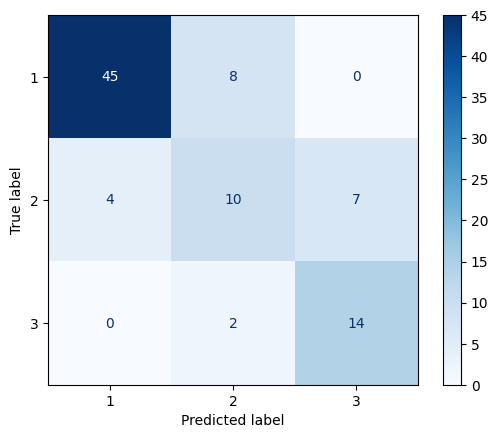

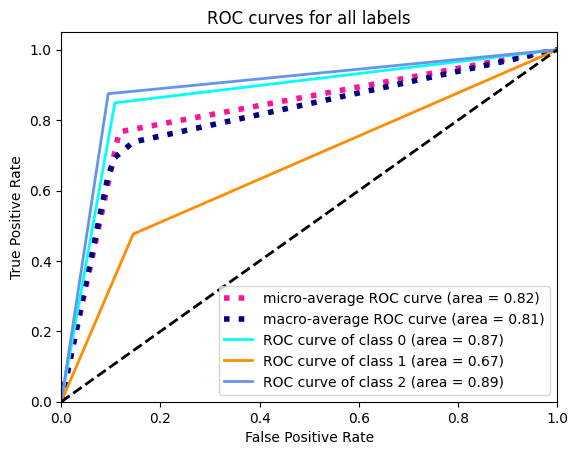

SVC
0.9777777777777777
{'C': 1000, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        53
           2       1.00      0.90      0.95        21
           3       0.89      1.00      0.94        16

    accuracy                           0.98        90
   macro avg       0.96      0.97      0.96        90
weighted avg       0.98      0.98      0.98        90



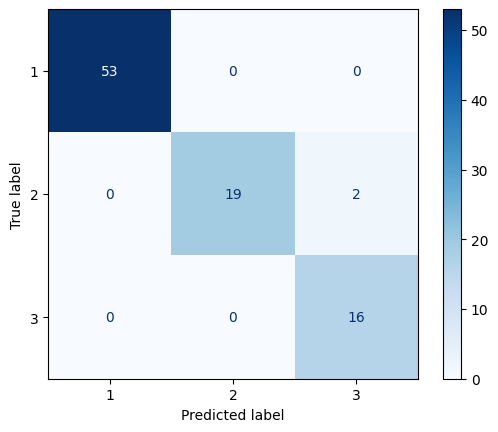

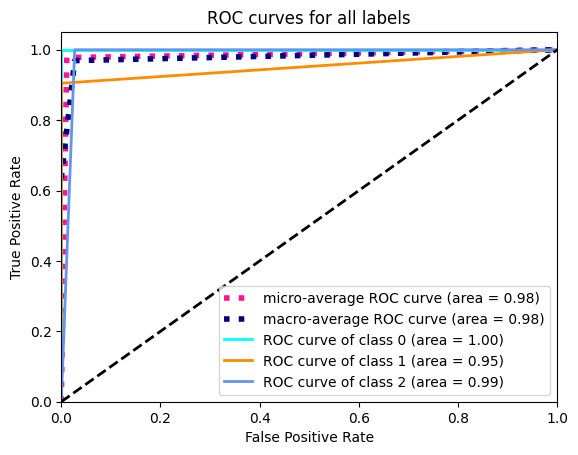

DecisionTreeClassifier
1.0
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        53
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        16

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



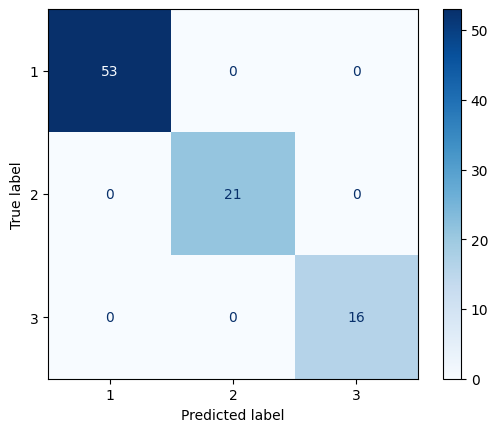

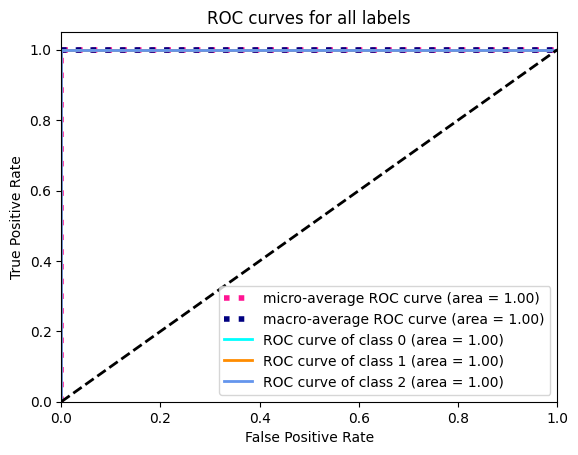

KNeighborsClassifier
0.84375
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
              precision    recall  f1-score   support

           1       0.85      0.89      0.87        76
           2       0.77      0.80      0.79        66
           3       0.95      0.82      0.88        50

    accuracy                           0.84       192
   macro avg       0.86      0.84      0.85       192
weighted avg       0.85      0.84      0.84       192



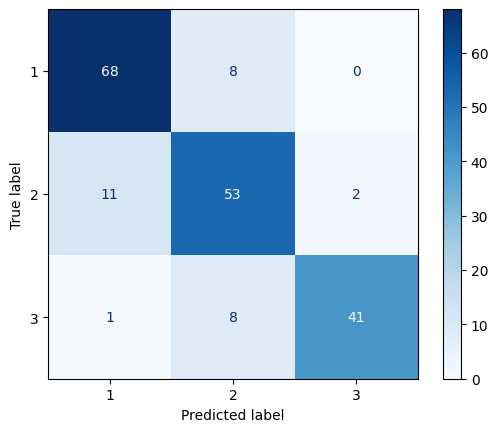

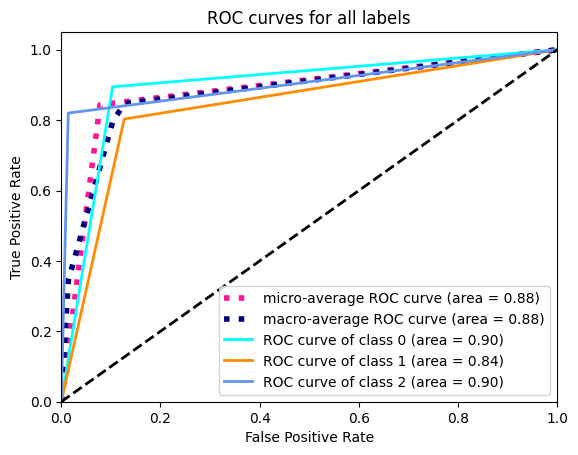

RandomForestRegressor
1.0
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        66
           3       1.00      1.00      1.00        50

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



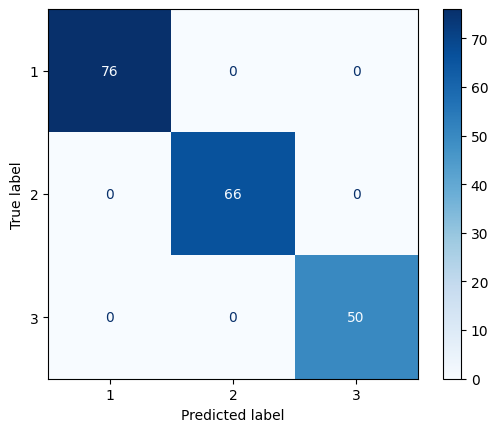

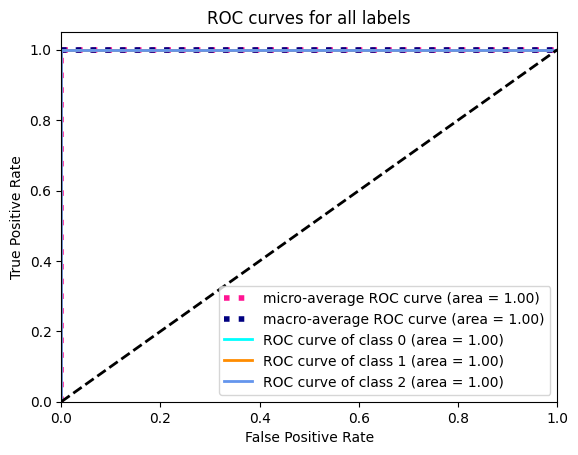

GaussianNB
0.8489583333333334
{'priors': None, 'var_smoothing': 0.0005336699231206307}
              precision    recall  f1-score   support

           1       0.93      0.88      0.91        76
           2       0.78      0.79      0.78        66
           3       0.83      0.88      0.85        50

    accuracy                           0.85       192
   macro avg       0.85      0.85      0.85       192
weighted avg       0.85      0.85      0.85       192



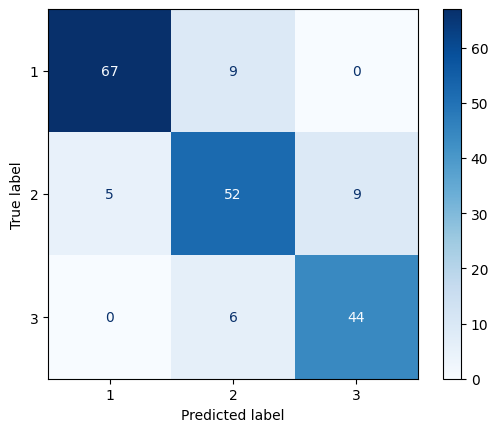

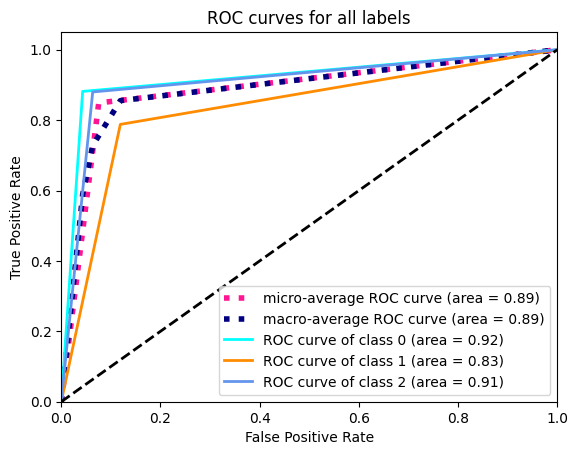

BernoulliNB
0.703125
{'alpha': 0.1, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}
              precision    recall  f1-score   support

           1       0.86      0.87      0.86        76
           2       0.58      0.48      0.53        66
           3       0.62      0.74      0.67        50

    accuracy                           0.70       192
   macro avg       0.69      0.70      0.69       192
weighted avg       0.70      0.70      0.70       192



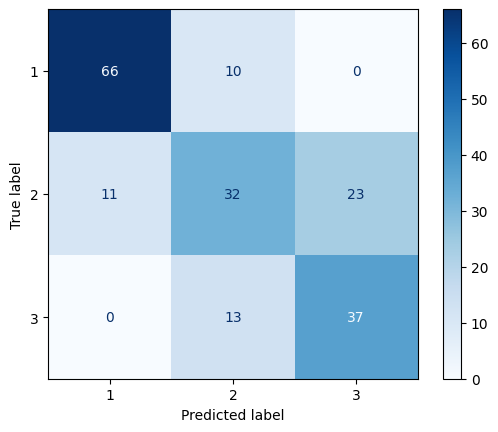

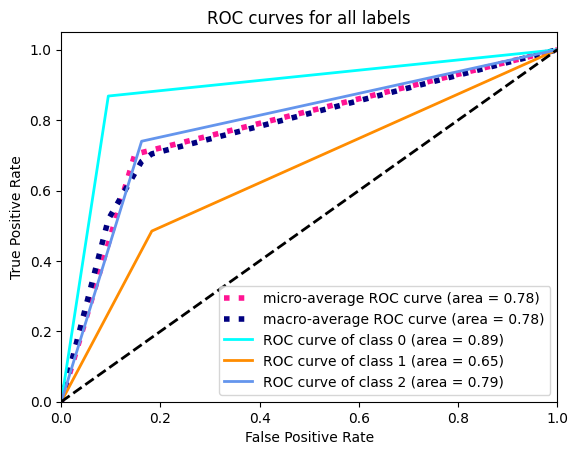

SVC
1.0
{'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        66
           3       1.00      1.00      1.00        50

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



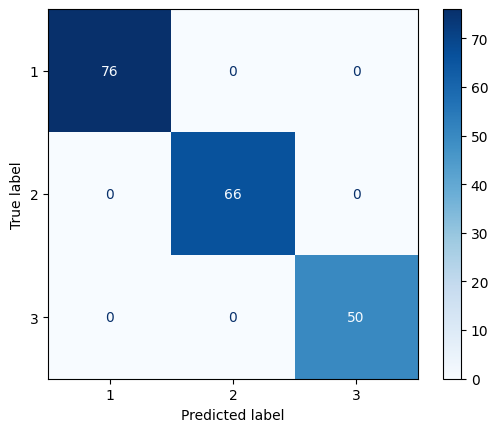

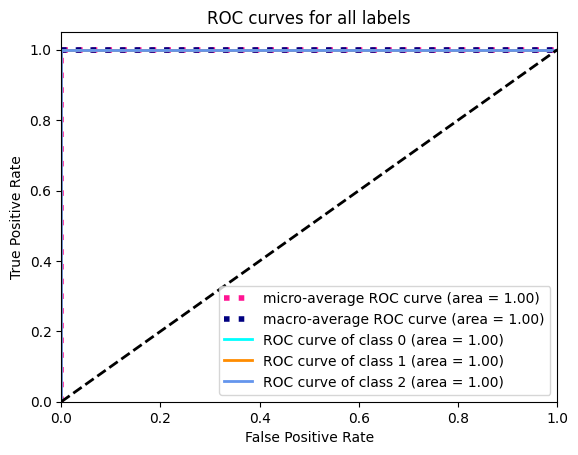

DecisionTreeClassifier
1.0
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        66
           3       1.00      1.00      1.00        50

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



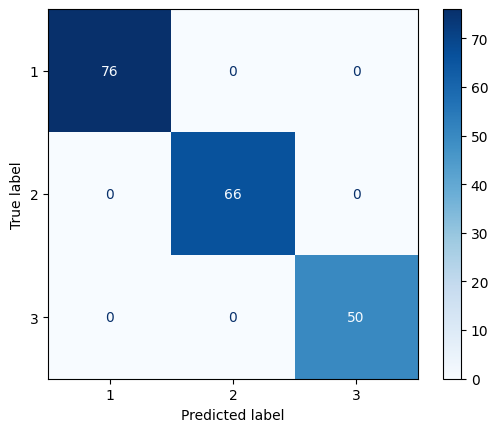

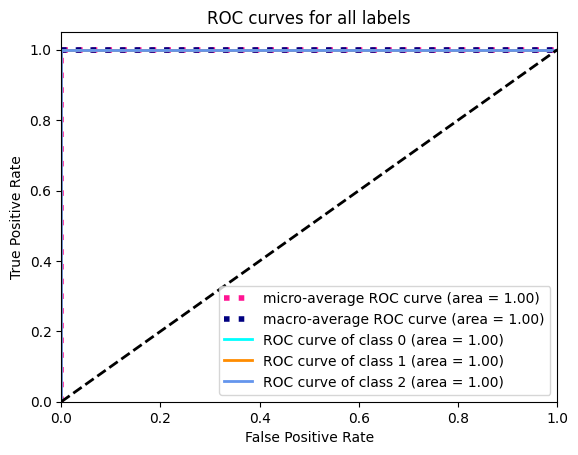

In [101]:
best_cz_estimator = get_best_estimator('Czech', x_train_cz, x_test_cz, y_train_cz.values, y_test_cz.values)
best_o_estimator = get_best_estimator('General', x_train_o, x_test_o, y_train_o.values, y_test_o.values)

In [ ]:
print('Best estimator for Czech: \n' + str(best_cz_estimator))
print('Best estimator for other countries: \n' + str(best_o_estimator))

In [99]:
loaded_model = joblib.load('models/General/SVC')

print(x_train_o[0].reshape(1, -1))

score = loaded_model.predict(x_train_o[0].reshape(1, -1))
print(y_train_o.values[0])
print(score)

[[-0.24216784 -0.25672372 -0.03388052 -0.30032498 -0.07865291 -0.52939804
   0.24234088 -0.19052635 -0.26371173 -0.61144378 -1.05309294 -0.49518356]]
2
[2]
